In [26]:
from sklearn.datasets import fetch_openml
import numpy as np

In [3]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

In [33]:
y = y.astype(np.uint8)

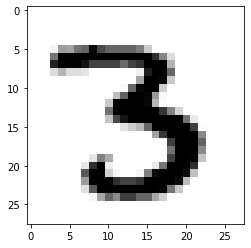

In [14]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
some_digit = X[12] 
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest") 
plt.axis("on")
plt.show()

In [34]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [36]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits. 
y_test_5 = (y_test == 5)

In [49]:
#np.unique(y)
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [37]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [53]:
sgd_clf.predict([some_digit])


array([False])

In [54]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5): 
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index] 
    y_train_folds = y_train_5[train_index] 
    X_test_fold = X_train[test_index] 
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds) 
    y_pred = clone_clf.predict(X_test_fold) 
    n_correct = sum(y_pred == y_test_fold) 
    print(n_correct / len(y_pred)) # prints 0.9502, 0.96565 and 0.96495

0.95035
0.96035
0.9604


In [55]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])